#OfficeObjects Classifier

This notebook implements an Office Item Classifier using Transfer Learning (ResNet-50) in PyTorch.  
It classifies 10 common office items such as bottle, mug, stapler, and keyboard from single images or a live camera feed.

Group: The Back Propagators  

#Notebook Outline
1. Setup & Imports  
2. Dataset Preparation  
3. Model (Transfer Learning: ResNet-50)  
4. Training  
5. Evaluation & Metrics (Accuracy, F1-score, Confusion Matrix)  
6. Live Detection (Camera Input)  
7. Dataset Card  
8. Conclusion & Error Analysis

Dataset Card

Dataset Name: OfficeObjects-10  
Task Image Classification (Single object per image)  
Classes (10): Bottle, Mug, Book, Folder, Mouse, Pen/Pencil, Calculator, Tape Dispenser, Stapler, Keyboard  

Data Source: 
- ~30% images captured using webcam or mobile.  
- ~70% from public datasets (Google/Open Images).  

Split:
- Train: 70%  
- Validation: 15%  
- Test: 15%

Image Format: `.jpg` or `.png`  
Augmentation: Random flip, rotation, brightness, resize (224x224)  

In [37]:
#Setup and Configuration
import os, time, copy, torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda:0
GPU: NVIDIA GeForce MX330


In [38]:
#Data Loading and Augmentation
data_dir = "data"  
batch_size = 16

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
NUM_CLASSES = len(class_names)

print(f"Classes found: {class_names}")
print(f"Train: {dataset_sizes['train']}  Val: {dataset_sizes['val']}  Test: {dataset_sizes['test']}")

Classes found: ['Book', 'Bottle', 'Calculator', 'File_Folder', 'Keyboard', 'Mouse', 'Mug', 'Pen_Pencil', 'Stapler', 'Tape_Dispenser']
Train: 2257  Val: 379  Test: 570


In [39]:
#Model Setup
model_ft = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Unfreeze last two ResNet blocks + FC layer
for name, param in model_ft.named_parameters():
    if "layer4" in name or "layer3" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(num_ftrs, NUM_CLASSES)
)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.AdamW(filter(lambda p: p.requires_grad, model_ft.parameters()),
                           lr=1e-4, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='max', factor=0.5, patience=2, verbose=True)

print("Model setup complete — Fine-tuning layer3, layer4, and fc")

Model setup complete — Fine-tuning layer3, layer4, and fc


c:\Users\krish\anaconda3\envs\office_classifier_env\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [40]:
# Training Function with Early Stopping & LR Scheduler
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=6):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss, running_corrects = 0.0, 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == 'val':
                scheduler.step(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(best_model_wts, 'best_model_weights.pth')
                    print(f"Model improved — saved (val acc: {best_acc:.4f})")
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"⏸ Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'best_model_weights.pth')
    print(f"\nTraining complete — Best Val Acc: {best_acc*100:.2f}%")
    return model, history


Starting training...

Epoch 1/25
--------------------
Train Loss: 1.5078  Acc: 0.5401
Val Loss: 0.5401  Acc: 0.8391
Model improved — saved (val acc: 0.8391)

Epoch 2/25
--------------------
Train Loss: 0.6530  Acc: 0.8051
Val Loss: 0.4788  Acc: 0.8760
Model improved — saved (val acc: 0.8760)

Epoch 3/25
--------------------
Train Loss: 0.4185  Acc: 0.8697
Val Loss: 0.4496  Acc: 0.8549

Epoch 4/25
--------------------
Train Loss: 0.2923  Acc: 0.9127
Val Loss: 0.4286  Acc: 0.8760

Epoch 5/25
--------------------
Train Loss: 0.1969  Acc: 0.9424
Val Loss: 0.4950  Acc: 0.8628

Epoch 6/25
--------------------
Train Loss: 0.1396  Acc: 0.9597
Val Loss: 0.4852  Acc: 0.8786
Model improved — saved (val acc: 0.8786)

Epoch 7/25
--------------------
Train Loss: 0.1154  Acc: 0.9708
Val Loss: 0.4351  Acc: 0.8786

Epoch 8/25
--------------------
Train Loss: 0.0956  Acc: 0.9743
Val Loss: 0.4506  Acc: 0.8681

Epoch 9/25
--------------------
Train Loss: 0.0890  Acc: 0.9743
Val Loss: 0.4477  Acc: 0.8760



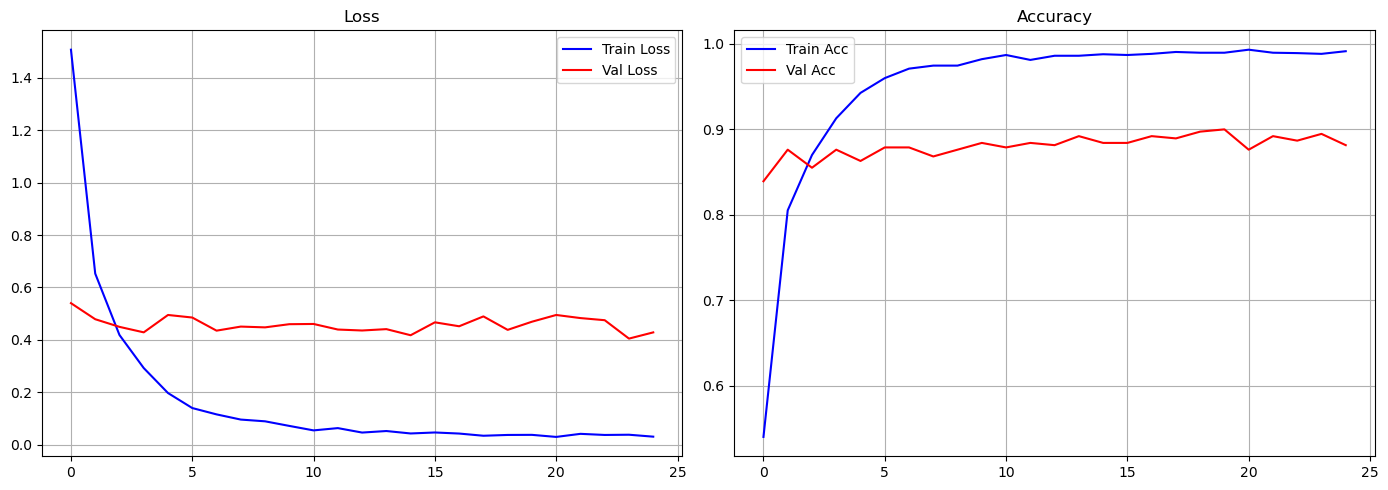

In [41]:
# Train the model
print("Starting training...")
model_ft, training_history = train_model(model_ft, criterion, optimizer_ft, scheduler, num_epochs=25)
print("Training finished!")

# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    epochs = range(len(history['train_loss']))
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    ax1.legend(); ax1.grid(True); ax1.set_title("Loss")

    ax2.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    ax2.plot(epochs, history['val_acc'], 'r-', label='Val Acc')
    ax2.legend(); ax2.grid(True); ax2.set_title("Accuracy")

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=150)
    plt.show()

plot_training_history(training_history)


Evaluating on test set...

Test Set Results:
Test Accuracy: 89.12%
Macro F1-Score: 0.8860


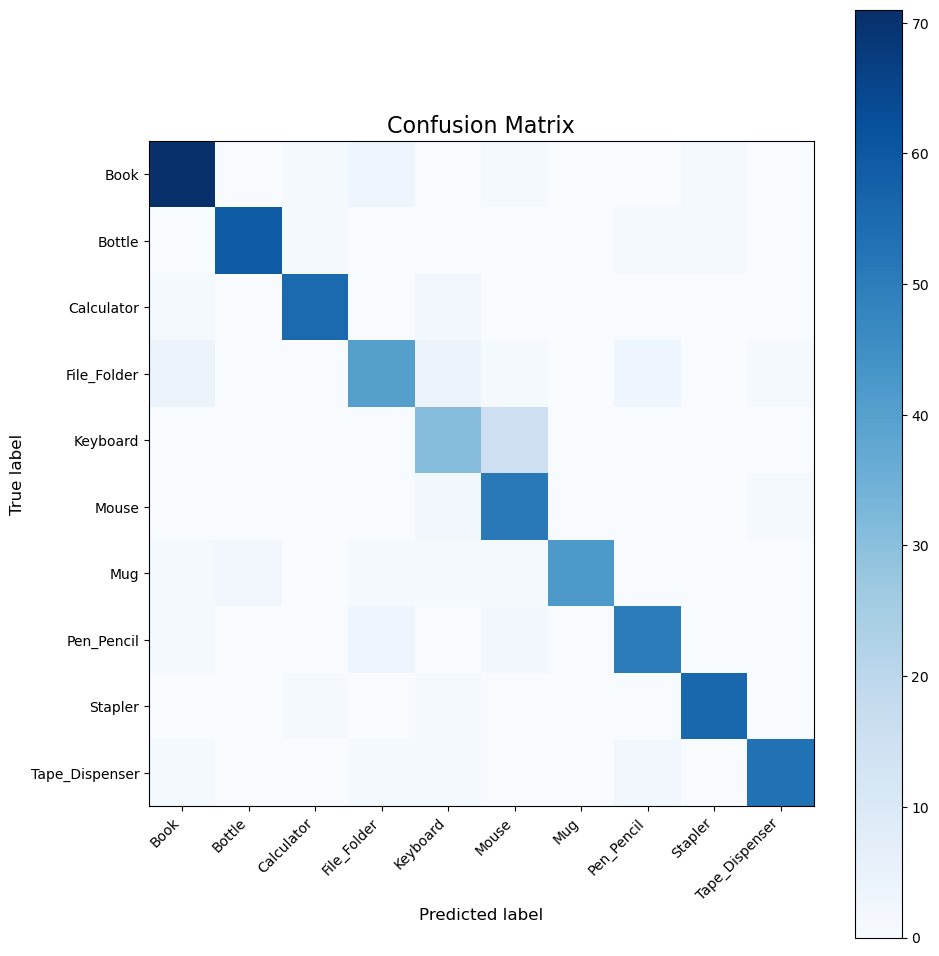


Metrics and confusion matrix saved!


In [43]:
#Evaluation and Metrics on Test Set

model_ft.eval()

all_preds = []
all_labels = []

# Collect all predictions on the test set
print("Evaluating on test set...")
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate Required Metrics
test_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
macro_f1 = f1_score(all_labels, all_preds, average='macro')

# Save the metrics to a file
with open('evaluation_metrics.txt', 'w') as f:
    f.write(f"Test Accuracy: {test_accuracy*100:.2f}%\n")
    f.write(f"Macro F1-Score: {macro_f1:.4f}\n")
    f.write("\nClassification Report:\n")
    f.write(classification_report(all_labels, all_preds, target_names=class_names))

print(f"\nTest Set Results:")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Macro F1-Score: {macro_f1:.4f}")

# Confusion Matrix Visualization
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=16)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)
plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nMetrics and confusion matrix saved!")


Performing Error Analysis on Test Set...


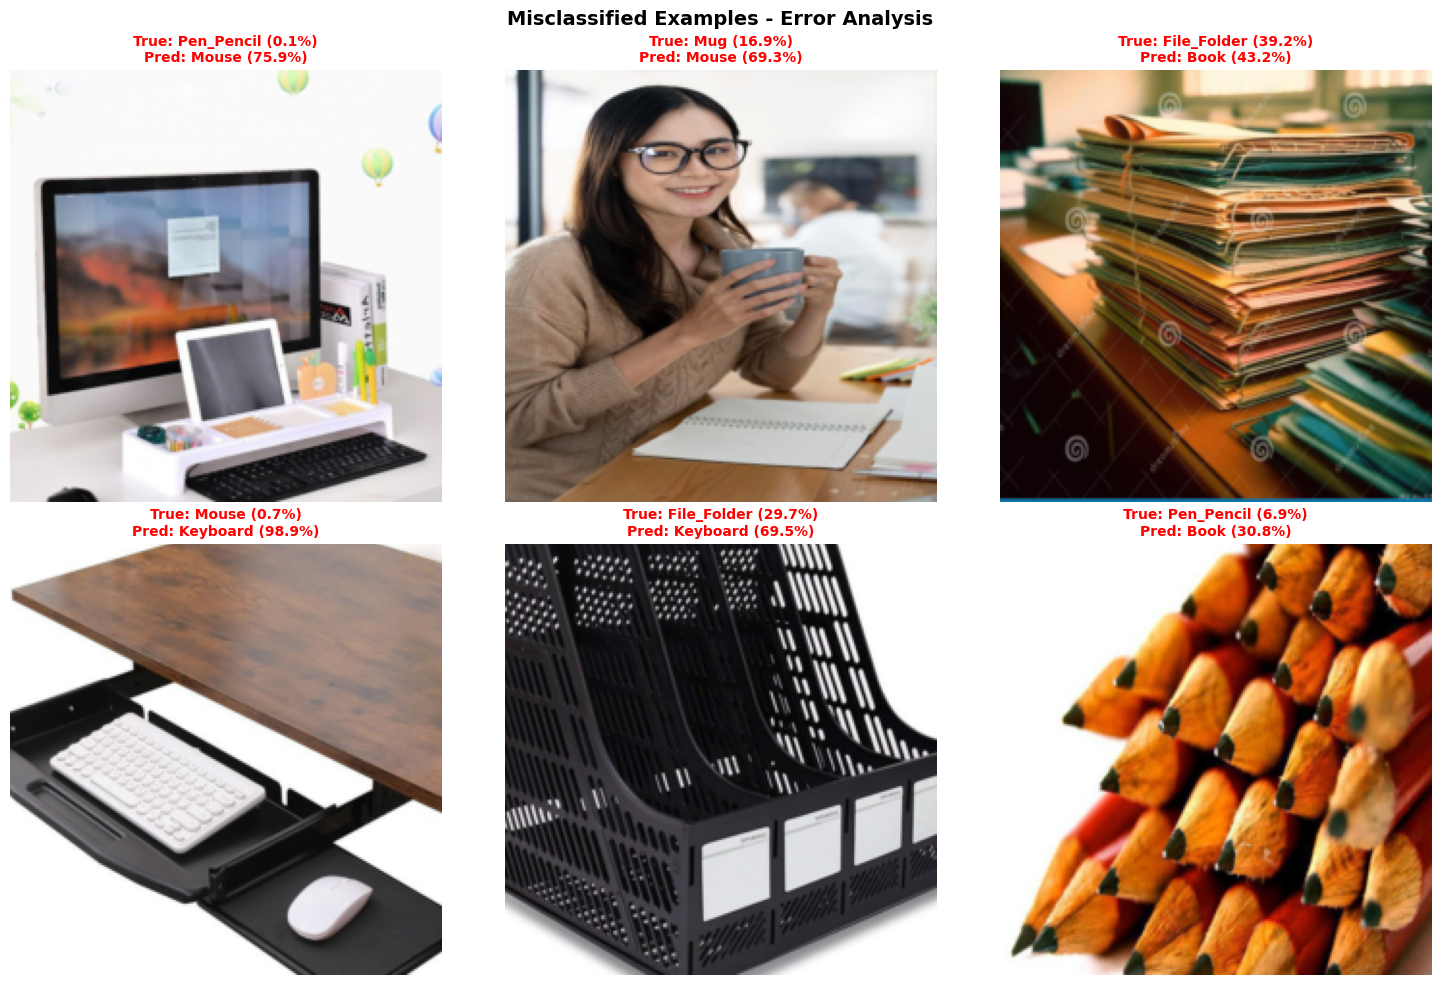


Error Analysis Summary:
Total misclassified: 6 / 570
Error rate: 1.05%

Most common misclassifications:
  • Pen_Pencil → Mouse: 1 times
  • Mug → Mouse: 1 times
  • File_Folder → Book: 1 times
  • Mouse → Keyboard: 1 times
  • File_Folder → Keyboard: 1 times


In [44]:
#Error Analysis - Misclassified Examples
def show_misclassified_examples(model, dataloader, class_names, device, num_examples=6):
    model.eval()
    misclassified = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            for i in range(inputs.size(0)):
                if preds[i] != labels[i]:
                    misclassified.append({
                        'image': inputs[i].cpu(),
                        'true': class_names[labels[i]],
                        'pred': class_names[preds[i]],
                        'conf': probs[i][preds[i]].item() * 100,
                        'true_conf': probs[i][labels[i]].item() * 100
                    })
                
                if len(misclassified) >= num_examples:
                    break
            if len(misclassified) >= num_examples:
                break
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, item in enumerate(misclassified[:num_examples]):
        img = item['image'].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = np.clip(std * img + mean, 0, 1)
        
        axes[idx].imshow(img)
        axes[idx].set_title(
            f"True: {item['true']} ({item['true_conf']:.1f}%)\n"
            f"Pred: {item['pred']} ({item['conf']:.1f}%)",
            color='red', fontsize=10, weight='bold'
        )
        axes[idx].axis('off')
    
    plt.suptitle('Misclassified Examples - Error Analysis', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.savefig('error_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nError Analysis Summary:")
    print(f"Total misclassified: {len(misclassified)} / {len(dataloader.dataset)}")
    print(f"Error rate: {len(misclassified) / len(dataloader.dataset) * 100:.2f}%")
    
    from collections import Counter
    misclass_pairs = [(m['true'], m['pred']) for m in misclassified]
    common = Counter(misclass_pairs).most_common(5)
    
    print("\nMost common misclassifications:")
    for (true, pred), count in common:
        print(f"  • {true} → {pred}: {count} times")

# Run error analysis
print("\nPerforming Error Analysis on Test Set...")
show_misclassified_examples(model_ft, dataloaders['test'], class_names, device, num_examples=6)

In [45]:
# Single-Image Prediction Function

def predict_single_image_robust(model, image_path, class_names, device, show_image=True):
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return
        
    # Load original image
    img = Image.open(image_path).convert('RGB')
        
    # Define multiple test transforms (TTA)
    tta_transforms = [
        # Original
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        # Horizontal flip
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        # Slight rotation
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomRotation(degrees=10),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    ]
        
    model.eval()
    all_probs = []
        
    with torch.no_grad():
        for transform in tta_transforms:
            image_tensor = transform(img).unsqueeze(0).to(device)
            outputs = model(image_tensor)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_probs.append(probs)
            
    avg_probs = torch.mean(torch.cat(all_probs, dim=0), dim=0)
    confidence, predicted_index = torch.max(avg_probs, 0)
        
    predicted_class = class_names[predicted_index.item()]
    confidence_percent = confidence.item() * 100
        
    # Top-3 predictions
    top3_conf, top3_idx = torch.topk(avg_probs, 3)
        
    print("-" * 60)
    print(f"Test Image: {os.path.basename(image_path)}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence_percent:.2f}%")
    print("\nTop 3 Predictions:")
    for i in range(3):
        print(f"  {i+1}. {class_names[top3_idx[i]]}: {top3_conf[i].item()*100:.2f}%")
    print("-" * 60)
        
    if show_image:
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        color = 'green' if confidence_percent > 60 else 'orange' if confidence_percent > 40 else 'red'
        plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence_percent:.2f}%",
                  fontsize=14, weight='bold', color=color)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    return predicted_class, confidence_percent


------------------------------------------------------------
Test Image: Image_23.png
Predicted Class: Mug
Confidence: 99.21%

Top 3 Predictions:
  1. Mug: 99.21%
  2. Calculator: 0.16%
  3. Bottle: 0.15%
------------------------------------------------------------


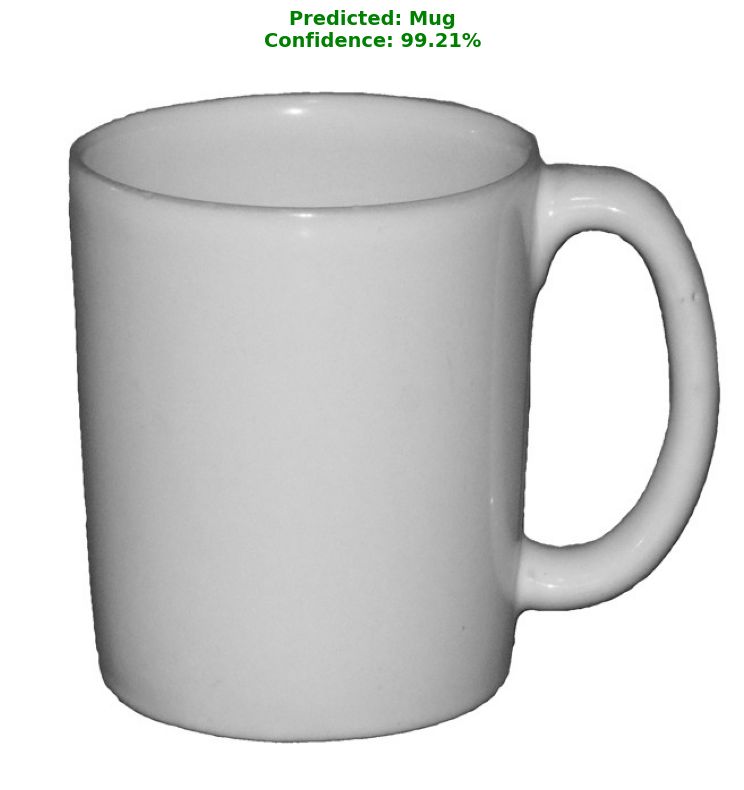

In [48]:
# Run a quick prediction test on one image

EXTERNAL_IMAGE_PATH = 'C:/Users/krish/OneDrive/Desktop/Office_Classification_Project/data/test/Mug/Image_23.png'  #change this to any test image path

if 'model_ft' in locals():
    predict_single_image_robust(model_ft, EXTERNAL_IMAGE_PATH, class_names, device)
else:
    print("Please run the notebook cells to train/load the 'model_ft' variable first.")

In [49]:
# Final Summary Cell - Model Performance & Saved Files
import os

print("="*70)
print("FINAL SUMMARY - OFFICE OBJECT CLASSIFIER RESULTS")
print("="*70)

# Display main metrics
try:
    print(f"Best Validation Accuracy : {max(training_history['val_acc'])*100:.2f}%")
except:
    print("Validation accuracy not found in history.")

try:
    print(f"Test Accuracy            : {test_accuracy*100:.2f}%")
    print(f"Macro F1-Score           : {macro_f1:.4f}")
except:
    print("Test metrics not available. Please run the evaluation cell.")

print("\nSaved Output Files:")
files = [
    "best_model_weights.pth",
    "training_history.png",
    "evaluation_metrics.txt",
    "confusion_matrix.png",
    "error_analysis.png"
]
for f in files:
    print(f"  {'✅' if os.path.exists(f) else '❌'} {f}")

print("\nTip: Use 'best_model_weights.pth' with your UI.py for real-time classification!")
print("="*70)


FINAL SUMMARY - OFFICE OBJECT CLASSIFIER RESULTS
Best Validation Accuracy : 89.97%
Test Accuracy            : 89.12%
Macro F1-Score           : 0.8860

Saved Output Files:
  ✅ best_model_weights.pth
  ✅ training_history.png
  ✅ evaluation_metrics.txt
  ✅ confusion_matrix.png
  ✅ error_analysis.png

Tip: Use 'best_model_weights.pth' with your UI.py for real-time classification!
